In [18]:
import os
import numpy as np
import torch
from torch import nn
from torch import optim 
from torch.autograd import Variable
import torch.utils.data as data
import torchvision
from torchvision import models
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

res_18_model = models.resnet18(pretrained=True)

In [2]:
from torchvision.datasets import ImageFolder


In [3]:
T = transforms.Compose([
     transforms.Resize((224,224)),
     #transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
#download the dataset from here: https://www.kaggle.com/alessiocorrado99/animals10 

In [4]:
dataset = ImageFolder('./archive/raw-img/', transform=T)


In [5]:
len(dataset)

26179

In [6]:
train_set, val_set = torch.utils.data.random_split(dataset, [int(len(dataset)*.8), len(dataset)-int(len(dataset)*.8)])

In [7]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64)
test_loader = torch.utils.data.DataLoader(val_set, batch_size=64)

In [19]:
res_18_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
res_18_model.fc= nn.Linear(512, 10)

In [21]:
res_18_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
res_18_model.fc= nn.Linear(512, 10)
if(torch.cuda.is_available()==True):
    model=res_18_model.cuda()

In [9]:
optimiser=optim.SGD(model.parameters(),lr=1e-2)
loss=nn.CrossEntropyLoss()

In [10]:
# My training and validation loops
nb_epochs = 5
acc_tot=np.zeros(nb_epochs)
for epoch in range(nb_epochs):
    losses = list()
    accuracies = list()
    model.train()     
    for batch in train_loader: 

        x,y = batch
        if(torch.cuda.is_available()==True):
            x=x.cuda()
            y=y.cuda()        


        # 1 forward
        l = model(x) # l: logits

        #2 compute the objective function
        J = loss(l,y)

        # 3 cleaning the gradients
        model.zero_grad()
        # optimiser.zero_grad()
        # params.grad.zero_()

        # 4 accumulate the partial derivatives of J wrt params
        J.backward()

        # 5 step in the opposite direction of the gradient
        optimiser.step()



        losses.append(J.item())
        accuracies.append(y.eq(l.detach().argmax(dim=1)).float().mean())

    print(f'Epoch {epoch + 1}', end=', ')
    print(f'training loss: {torch.tensor(losses).mean():.2f}', end=', ')
    print(f'training accuracy: {torch.tensor(accuracies).mean():.2f}')


    losses = list()
    accuracies = list() 
    model.eval()
    for batch in test_loader: 
        x,y = batch
        if(torch.cuda.is_available()==True):
            x=x.cuda()
            y=y.cuda()

        with torch.no_grad(): 
            l = model(x)

        #2 compute the objective function
        J = loss(l,y)

        losses.append(J.item())
        accuracies.append(y.eq(l.detach().argmax(dim=1)).float().mean())

    print(f'Epoch {epoch + 1}',end=', ')
    print(f'validation loss: {torch.tensor(losses).mean():.2f}', end=', ')
    print(f'validation accuracy: {torch.tensor(accuracies).mean():.2f}')
    acc_tot[epoch]=torch.tensor(accuracies).mean().numpy()


Epoch 1, training loss: 0.38, training accuracy: 0.90
Epoch 1, validation loss: 0.16, validation accuracy: 0.95
Epoch 2, training loss: 0.13, training accuracy: 0.97
Epoch 2, validation loss: 0.12, validation accuracy: 0.96
Epoch 3, training loss: 0.08, training accuracy: 0.98
Epoch 3, validation loss: 0.11, validation accuracy: 0.97
Epoch 4, training loss: 0.05, training accuracy: 0.99
Epoch 4, validation loss: 0.10, validation accuracy: 0.97
Epoch 5, training loss: 0.03, training accuracy: 1.00
Epoch 5, validation loss: 0.10, validation accuracy: 0.97


In [11]:
def imformat(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return(inp)


In [12]:
class_names = dataset.classes
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "dog": "cane", "cavallo": "horse", "elephant" : "elefante", "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca", "spider": "ragno", "squirrel": "scoiattolo"}
t_inv = {v: k for k, v in translate.items()}



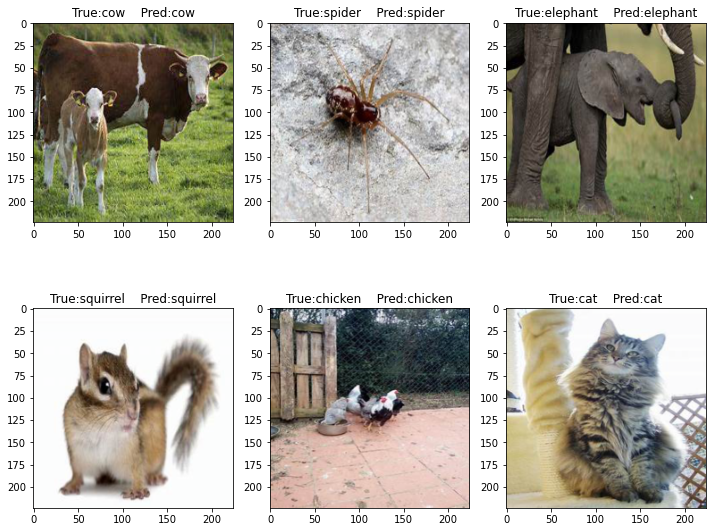

In [42]:
#train_loader2 = torch.utils.data.DataLoader(train_set, batch_size=9)

plt.figure(figsize=(10, 12))

inputs, classes = next(iter(train_loader2))
preds=model(inputs.cuda()).argmax(dim=1)


for i in range(0,6):
    ax = plt.subplot(3, 3, i + 1)
    img=imformat(inputs[i])
    
    plt.imshow((img))

    try:
        plt.title('True:'+str(t_inv[class_names[classes[i]]])+'    Pred:'+str(t_inv[class_names[preds[i]]]))
    except:
        plt.title('True:'+str(translate[class_names[classes[i]]])+'    Pred:'+str(translate[class_names[preds[i]]]))
    #if(i==5):
        #plt.axis("off")
plt.tight_layout()
plt.savefig('vis.png',dpi=600)